In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from nvae_layers import SqueezeExciteLayer, FactorizedDownsample, ResidualDecoderCell, ResidualEncoderCell
from dataset_utils import LfwDataset

print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={tf.keras.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU(s) available")
else:
    print("GPU(s) Available: ") 
    for g in gpus:
        print('  ', g)

Using Python=3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
Using Tensorflow=2.3.0
Using Keras=2.4.0
GPU(s) Available: 
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [33]:
#!nvidia-smi

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
lfw = LfwDataset()
lfw.tfds_load()

<ShuffleDataset shapes: (160, 160, 3), types: tf.float32>
0000 (160, 160, 3)
0001 (160, 160, 3)
0002 (160, 160, 3)
<MapDataset shapes: (160, 160, 3), types: tf.float32>
0000 (160, 160, 3)
0001 (160, 160, 3)
0002 (160, 160, 3)
<MapDataset shapes: (160, 160, 3), types: tf.float32>
0000 (160, 160, 3)
0001 (160, 160, 3)
0002 (160, 160, 3)
Train samples: 10586 <class 'tensorflow.python.data.ops.dataset_ops.ShuffleDataset'>
Val samples:   1324 <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
Test samples:  1323 <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
Display test image shape: (32, 160, 160, 3)


In [8]:
test_nfilt = 32
rdc = ResidualDecoderCell(expand_ratio=4, se_ratio=8, bn_momentum=0.9, gamma_reg=None)

cexpand = L.Conv2D(filters=test_nfilt, kernel_size=1, strides=1, padding='same')
test_input = cexpand(lfw.data_sample[:8])

rdc(test_input, training=True)
rdc(test_input, training=False)
print(test_input.shape)
dmodel = rdc.build(test_input.shape)
dmodel = rdc.create_model(test_input.shape[1:])
dmodel.summary()

Disabled Spectral Normalization (temp)
(8, 160, 160, 32)
Disabled Spectral Normalization (temp)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 32 0                                            
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 160, 160, 32) 128         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 160, 160, 128 4224        batch_normalization_14[0][0]     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 160, 160, 128 512         conv2d_16[0][0]          

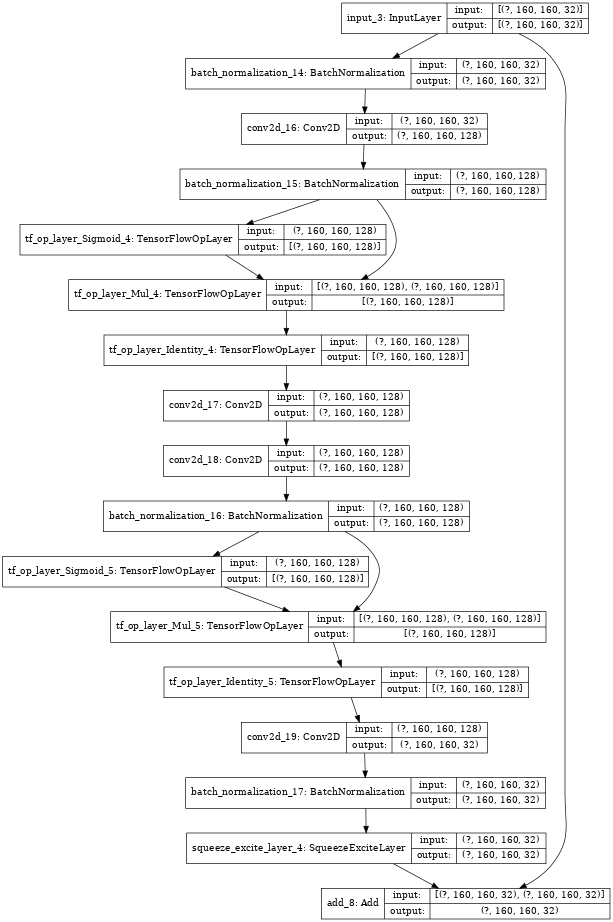

In [9]:
tf.keras.utils.plot_model(dmodel, show_shapes=True, dpi=48)

In [6]:

rec = ResidualEncoderCell(se_ratio=8)
test_nfilt = 32
rec(test_input).shape
emodel = rec.create_model(test_input.shape[1:])
emodel.summary()

Disabled Spectral Normalization (temp)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 32 0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 160, 160, 32) 128         input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sigmoid_2 (TensorFl [(None, 160, 160, 32 0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
tf_op_layer_Mul_2 (TensorFlowOp [(None, 160, 160, 32 0           batch_normalization_8[0][0]      
                                                

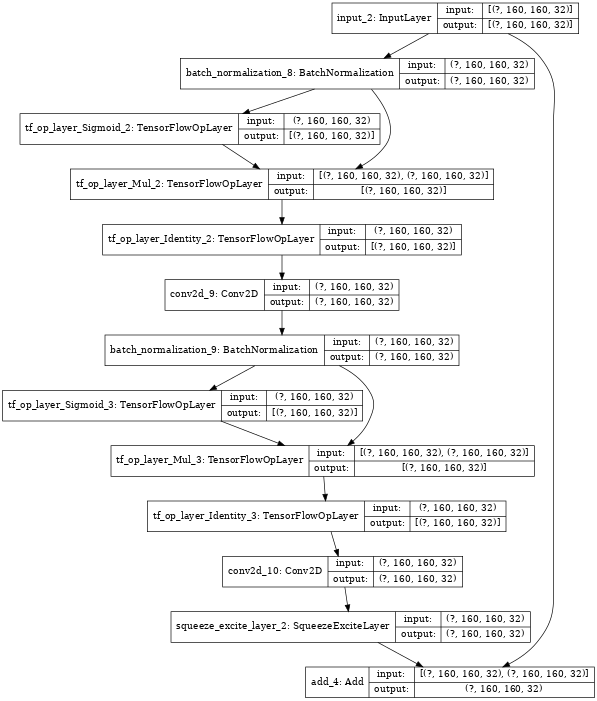

In [10]:
tf.keras.utils.plot_model(emodel, show_shapes=True, dpi=48)

In [ ]:
tf.keras.layers.

In [7]:
with tf.GradientTape() as tape:
    out = rdc(test_input, training=True)

print([l.shape for l in tape.gradient(out, rdc.trainable_variables)])

[TensorShape([32]), TensorShape([32]), TensorShape([128]), TensorShape([128]), TensorShape([128]), TensorShape([128]), TensorShape([32]), TensorShape([32]), TensorShape([1, 1, 32, 128]), TensorShape([128]), TensorShape([5, 5, 1, 128]), TensorShape([128]), TensorShape([1, 1, 128, 128]), TensorShape([128]), TensorShape([1, 1, 128, 32]), TensorShape([32]), TensorShape([32, 4]), TensorShape([4]), TensorShape([4, 32]), TensorShape([32])]
